In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, RocCurveDisplay

Accuracy:  68.29
Precision score:  27.94
Recall score:  4.74
F-1 score:  8.1


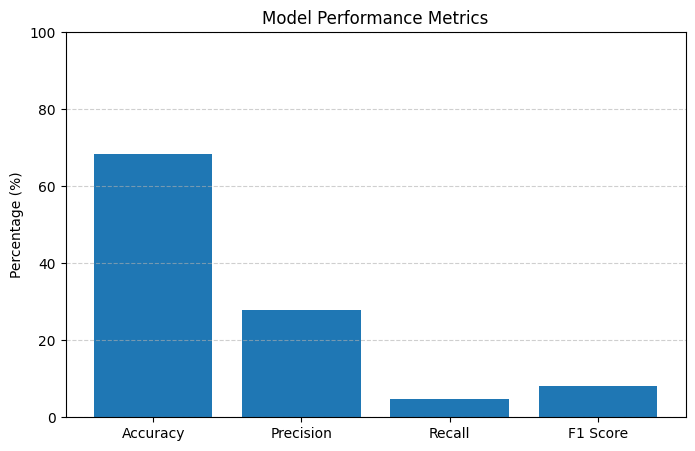

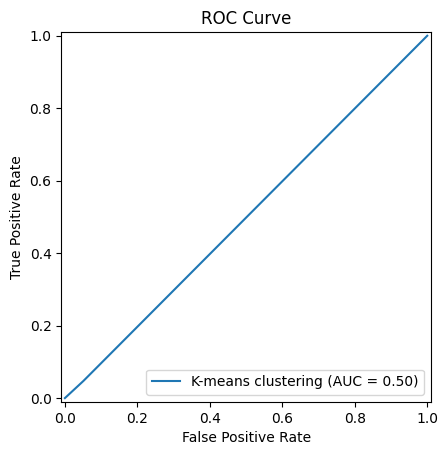

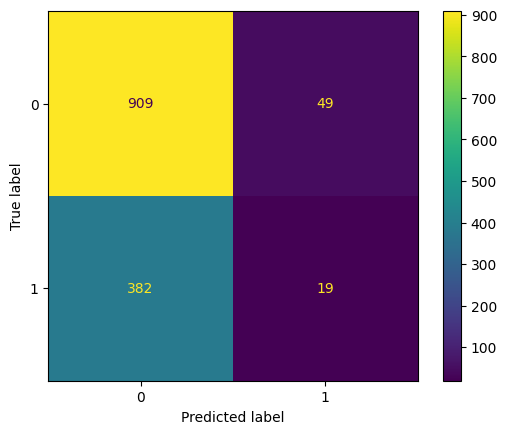

In [ ]:
pipeline = joblib.load("kmeans_model.pkl")

path = os.path.abspath("..") + '/' + "datasets/script_dataset.csv"
df = pd.read_csv(path)

attack_cols = ['label_spoofing', 'label_mitm', 'label_ddos', 'label_gps_spoofing',
               'label_gps_spoofing', 'label_malware', 'label_jamming', 'label_protocol_exploit']

df = df.drop(['timestamp', 'drone_gps_coordinates', 'label_normal'], axis=1)
df['anomaly'] = df[attack_cols].max(axis=1)
df = df.drop(columns=attack_cols)
y_actual = df['anomaly']
df = df.drop(columns=['anomaly'])

categorical = ['communication_protocol', 'encryption_type']
numeric = [col for col in df.columns if col not in categorical]

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[['communication_protocol', 'encryption_type']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['communication_protocol', 'encryption_type']))
df = pd.concat([df.drop(['communication_protocol', 'encryption_type'], axis=1), encoded_df], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

labels = pipeline.predict(X_pca)
centers = pipeline.cluster_centers_
distances = np.linalg.norm(X_pca - centers[labels], axis=1)
#print(len(distances))
threshold = np.percentile(distances, 95)
#print(threshold)
y_pred = [] 
for dis in distances:
    anomaly = 1 if dis > threshold else 0
    y_pred.append(anomaly)
    
#comparative metrics
y_pred = pd.DataFrame(y_pred)

accuracy = accuracy_score(y_actual, y_pred)
print("Accuracy: ", round(accuracy*100, 2))

precision = precision_score(y_actual, y_pred)
print("Precision score: ", round(precision*100, 2))

recall = recall_score(y_actual, y_pred)
print("Recall score: ", round(recall*100, 2))

f1_score = f1_score(y_actual, y_pred)
print("F-1 score: ", round(f1_score*100, 2))

metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1_score
}

names = list(metrics.keys())
values = [v * 100 for v in metrics.values()]

plt.figure(figsize=(8, 5))
plt.bar(names, values)
plt.ylabel("Percentage (%)")
plt.title("Model Performance Metrics")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


#ROC Curve
fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
roc_auc = roc_auc_score(y_actual, y_pred)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, name='K-means clustering')
display.plot()
plt.title('ROC Curve')
plt.show()

#Confusion matrix
cm = confusion_matrix(y_actual, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()